In [306]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Data Import

In [2]:
train_data = pd.read_csv('train.csv')
train_data.shape

(5500, 23)

In [3]:
train_data.columns

Index(['Choice', 'A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3'],
      dtype='object')

In [4]:
y = train_data['Choice']
X = train_data.drop('Choice', axis = 1)

In [5]:
test_data = pd.read_csv('test.csv')
test_data.shape

(5952, 22)

In [6]:
test_data.columns

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3'],
      dtype='object')

In [7]:
y.value_counts()

1    2802
0    2698
Name: Choice, dtype: int64

## Data Preprocessing

### 1. Transformation : Dividing(A/B)
### 2. Transformation : Difference (A>B)

In [185]:
def transformations(data):
    data['A_pop_ratio'] = data['A_mentions_sent']/(data['A_listed_count'] + 0.001)
    data['A_foll_ratio'] = data['A_follower_count']/(data['A_following_count'] + 0.001)
    data['A_ment_ratio'] = data['A_mentions_sent']/(data['A_mentions_received'] + 0.001)
    data['A_rt_ratio'] = data['A_retweets_sent']/(data['A_retweets_received'] + 0.001)

    data['B_pop_ratio'] = data['B_mentions_sent']/(data['B_listed_count'] + 0.001)
    data['B_foll_ratio'] = data['B_follower_count']/(data['B_following_count'] + 0.001)
    data['B_ment_ratio'] = data['B_mentions_sent']/(data['B_mentions_received'] + 0.001)
    data['B_rt_ratio'] = data['B_retweets_sent']/(data['B_retweets_received'] + 0.001)
    
    # Transforming A and B variables -- A > B
    data['A-B_follower_count'] = (data['A_follower_count'] > data['B_follower_count'])
    data['A-B_following_count'] = (data['A_following_count'] > data['B_following_count'])
    data['A-B_listed_count'] = (data['A_listed_count'] > data['B_listed_count'])
    data['A-B_mentions_received'] = (data['A_mentions_received'] > data['B_mentions_received'])
    data['A-B_retweets_received'] = (data['A_retweets_received'] > data['B_retweets_received'])
    data['A-B_mentions_sent'] = (data['A_mentions_sent'] > data['B_mentions_sent'])
    data['A-B_retweets_sent'] = (data['A_retweets_sent'] > data['B_retweets_sent'])
    data['A-B_posts'] = (data['A_posts'] > data['B_posts'])
    data['A-B_network_feature_1'] = (data['A_network_feature_1'] > data['B_network_feature_1'])
    data['A-B_network_feature_2'] = (data['A_network_feature_2'] > data['B_network_feature_2'])
    data['A-B_network_feature_3'] = (data['A_network_feature_3'] > data['B_network_feature_3'])
    data['A-B_foll_ratio'] = (data['A_foll_ratio'] > data['B_foll_ratio'])
    data['A-B_ment_ratio'] = (data['A_ment_ratio'] > data['B_ment_ratio'])
    data['A-B_rt_ratio'] = (data['A_rt_ratio'] > data['B_rt_ratio'])
    
    return data

In [186]:
X_t = transformations(X)

sub_cols = ['A-B_follower_count',
'A-B_following_count',
'A-B_listed_count',
'A-B_mentions_received',
'A-B_retweets_received',
'A-B_mentions_sent',
'A-B_retweets_sent',
'A-B_posts',
'A-B_network_feature_1',
'A-B_network_feature_2',
'A-B_network_feature_3',
'A-B_foll_ratio',
'A-B_ment_ratio',
'A-B_rt_ratio']

<AxesSubplot:>

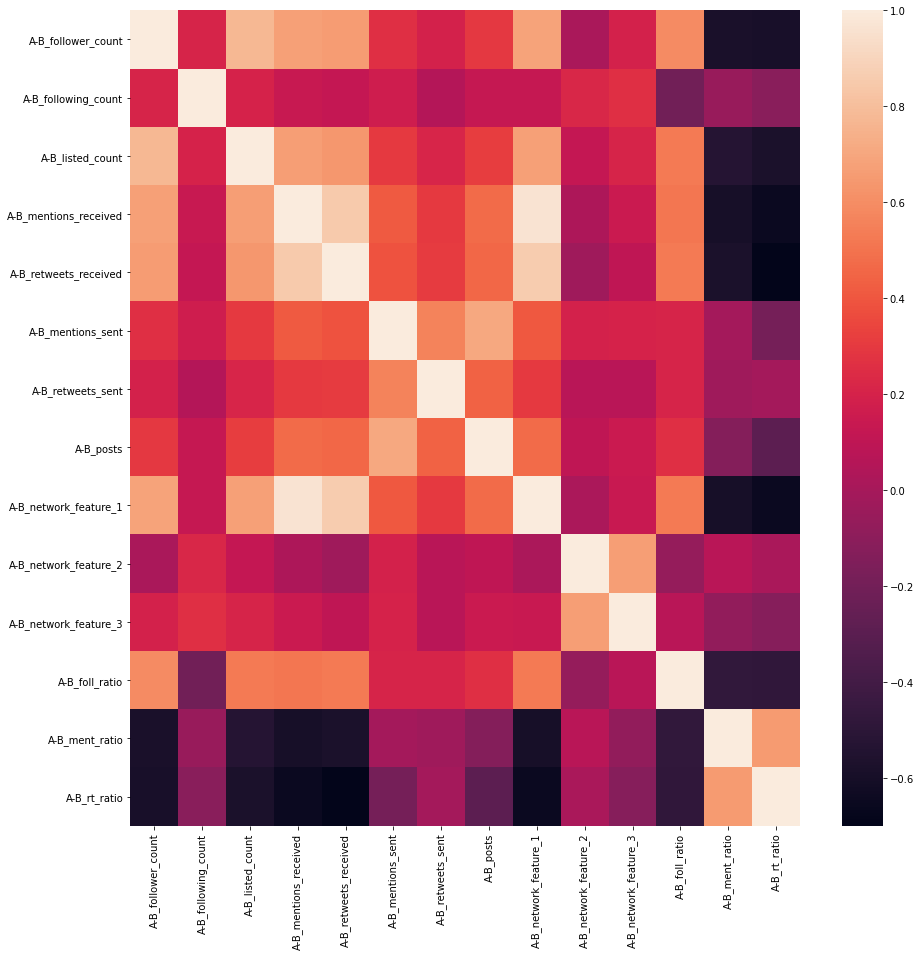

In [187]:
Var_Corr = X_t[sub_cols].corr()

plt.figure(figsize=(15,15))
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

### Variance Inflation factor to filter out highly correlated features

In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = X_t[sub_cols]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]

In [189]:
vif_data

,feature,VIF
0,A-B_follower_count,0.002443
1,A-B_following_count,0.000927
2,A-B_listed_count,0.002096
3,A-B_mentions_received,0.009857
4,A-B_retweets_received,0.003202
5,A-B_mentions_sent,0.001849
6,A-B_retweets_sent,0.001215
7,A-B_posts,0.001602
8,A-B_network_feature_1,0.010381
9,A-B_network_feature_2,0.001411


In [190]:
selected_cols = vif_data[vif_data['VIF'] <= 5]['feature'].values.tolist()

In [191]:
selected_cols

['A-B_follower_count',
 'A-B_following_count',
 'A-B_listed_count',
 'A-B_mentions_received',
 'A-B_retweets_received',
 'A-B_mentions_sent',
 'A-B_retweets_sent',
 'A-B_posts',
 'A-B_network_feature_1',
 'A-B_network_feature_2',
 'A-B_network_feature_3',
 'A-B_foll_ratio',
 'A-B_ment_ratio',
 'A-B_rt_ratio']

## Feature Selection

In [240]:
X = X_t[selected_cols]

In [241]:
# building the model and fitting the data
log_reg = sm.Logit(y, X).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.516642
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Choice   No. Observations:                 5500
Model:                          Logit   Df Residuals:                     5486
Method:                           MLE   Df Model:                           13
Date:                Thu, 03 Feb 2022   Pseudo R-squ.:                  0.2545
Time:                        22:47:02   Log-Likelihood:                -2841.5
converged:                       True   LL-Null:                       -3811.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
A-B_follower_count        0.3635      0.108      3.374      0.001       0.152       0.

In [248]:
del_columns = [
    'A-B_following_count',
    'A-B_mentions_received',
    'A-B_posts',
    'A-B_network_feature_3',
    'A-B_foll_ratio'
]
req_cols = list(set(sub_cols) - set(del_columns))

In [249]:
# building the model and fitting the data
log_reg = sm.Logit(y, X[log_reg_columns]).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.517359
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Choice   No. Observations:                 5500
Model:                          Logit   Df Residuals:                     5491
Method:                           MLE   Df Model:                            8
Date:                Thu, 03 Feb 2022   Pseudo R-squ.:                  0.2534
Time:                        22:49:36   Log-Likelihood:                -2845.5
converged:                       True   LL-Null:                       -3811.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
A-B_retweets_received    -0.2927      0.120     -2.448      0.014      -0.527      -0.

all features are significant

## Running different models on difference transformations

In [298]:
X_train, X_val, y_train, y_val = train_test_split(X_t[log_reg_columns], y, test_size=0.3, random_state=42)

In [299]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7763636363636364

In [300]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7618181818181818

In [301]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7636363636363637

In [302]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7466666666666667

In [303]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

[23:19:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7642424242424243

In [304]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7660606060606061

In [305]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7666666666666667

All models performed equally well

#### CV and hyper parameter Tuning for Logistic regression

In [282]:
# Number of trees in random forest
penalty = ['l1', 'l2', 'elasticnet', 'none']
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
gamma = [0.001, 0.0001]
kernel = ['rbf']
param_grid = {'solver': solvers,
               'penalty': penalty,
               'C': c_values} 

model = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv = 10,
                           n_jobs=-1,
                          verbose=3)


In [283]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=3)

In [284]:
log_reg_best = grid_search.best_estimator_
log_reg_best.fit(X_train, y_train)
y_pred = log_reg_best.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7763636363636364

#### CV and Hyperparameter tuning for RF 

In [285]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [287]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=3, 
    random_state=42,
    scoring = 'accuracy',
    n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, scoring='accuracy', verbose=3)

In [288]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}

In [289]:
rf_best = rf_random.best_estimator_

In [290]:
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7624242424242424

**Logistic regression performed the best with ~78% accuracy**

In [309]:
log_reg_best.fit(X_train, y_train)
y_pred = log_reg_best.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_pred=y_pred, y_true=y_val).ravel()

## Financial value of the model

If an influencer tweets once, there is a 0.01% chance that his/her followers will buy one unit of a product. Assume the retailer has a profit margin of \\$10 per unit, and that one customer can buy only one unit. If an influencer tweets twice, the overall buying probability will be 0.015\% Without analytics, the retailer offers \\$5 to each person (A and B) to tweet once. With analytics, the retailer offers \\$10 to those identified as influencer by the model to send two tweets each.

In [379]:
## choice for retailers based on follower count of a user
y_val_ix = y_val.index
val_data = train_data.iloc[y_val_ix]
profit_from_A = sum(0.0001 * val_data['A_follower_count'] * val_data['Choice']*10) - 5*sum(val_data['Choice'])
profit_from_B = sum(0.0001 * val_data['B_follower_count'] * (val_data['Choice']==0)*10) - 5*sum(val_data['Choice']==0)

In [382]:
profit_from_B

887292.7939999972

In [384]:
total_profit_wo_targeting = profit_from_A + profit_from_B
total_profit_wo_targeting

1697597.578999997

In [419]:
## Profit via targeting
profit_targeting_A = sum(0.00015 * val_data['A_follower_count']*y_val*y_pred*10) - 10*sum(y_pred)
profit_targeting_B = sum(0.00015 * val_data['B_follower_count']*(y_val == 0)*(y_pred == 0)*10) - 10*sum(y_pred==0)

total_profit_with_targeting = profit_targeting_A + profit_targeting_B
total_profit_with_targeting

2400434.1090000006

In [420]:
profit_increase = (total_profit_with_targeting - total_profit_wo_targeting) / total_profit_wo_targeting * 100

In [421]:
lift1 = total_profit_with_targeting - total_profit_wo_targeting
lift1

702836.5300000038

### Financial Lift of our model

In [434]:
#financial lift 
print(f'The financial lift from using our analytical model after identifying influencers : {round(lift1,2)}')

The financial lift from using our analytical model after identifying influencers : 702836.53


In [435]:
print(f'Percentage increase in profit after identifying influencers : {round(profit_increase,2)}%')

Percentage increase in profit after identifying influencers : 41.4%


### Financial Lift of Perfect Model

In [436]:
## Profit via targeting
profit_perfect_A = sum(0.00015 * val_data['A_follower_count']*val_data['Choice']*10) - 10*sum(val_data['Choice'])
profit_perfect_B = sum(0.00015 * val_data['B_follower_count']*(val_data['Choice'] == 0)*10) - 10*sum(val_data['Choice'])

total_profit_perfect = profit_perfect_A + profit_perfect_B
total_profit_perfect

2542171.3685000017

In [437]:
lift2 = total_profit_perfect - total_profit_wo_targeting

profit_increase2 = (total_profit_perfect - total_profit_wo_targeting) / total_profit_wo_targeting * 100

In [438]:
#financial lift 
print(f'The financial lift for a perfect analytical model : {round(lift2,2)}')

The financial lift for a perfect analytical model : 844573.79


In [439]:
print(f'Percentage increase in profit using perfect analytical model : {round(profit_increase2,2)}%')

Percentage increase in profit using perfect analytical model : 49.75%
